# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
scaler_id = "lowmass_scan"

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD"
path_to_compiled_data = f"{working_dir}/compiled_data/{project_id}"
    
    
run_jet = False
if run_jet:
    codes_list = ["DATA_jet"]
    sim_id = "DATA_jet" # should probably rename this to data_id
else:
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet" # should probably rename this to data_id
signal_id = ""

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet opp sign (21803678,)
DATA_nojet same sign (6756613,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features_dict([uncut_data[codes_list[0]]], codes_list, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

Random seed is used to set aside a portion of the test set

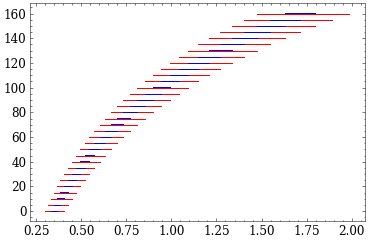

33
0.3 0.3313866376233613 0.36605701198438995 0.40435467459987157


In [5]:
# define SB / SR choices

detector_resolution = 0.01
start_mass = 0.3

current_mass = start_mass
all_bins = [start_mass]


while current_mass < 2:
    loc_bin_width = current_mass*detector_resolution
    current_mass += loc_bin_width
    all_bins.append(current_mass)
    

num_bins_total = len(all_bins)

SB_num_bins = 10
SR_num_bins = 10
window_gap = 5
window_length = 2*SB_num_bins + SR_num_bins



bin_definitions = {
    "SB_left":[],
    "SR_left":[],
    "SR_right":[],
    "SB_right":[],
}

window_index = 0
with open(f"{working_dir}/projects/{scaler_id}/processed_data/window_definitions.txt", "w") as ofile:
    
    plt.figure()

    for i in range(0, num_bins_total, window_gap):
        if i + window_length < num_bins_total:
            bin_definitions["SB_left"].append(all_bins[i])
            bin_definitions["SR_left"].append(all_bins[i+SB_num_bins])
            bin_definitions["SR_right"].append(all_bins[i+SB_num_bins+SR_num_bins])
            bin_definitions["SB_right"].append(all_bins[i+2*SB_num_bins+SR_num_bins])

            plt.plot([all_bins[i], all_bins[i+2*SB_num_bins+SR_num_bins]], [i, i], color = "red")
            plt.plot([all_bins[i+SB_num_bins], all_bins[i+SB_num_bins+SR_num_bins]], [i+0.25, i+0.25], color = "blue")
            ofile.write("window_{window_index} {SB_left} {SR_left} {SR_right} {SB_right}\n".format(window_index=window_index,
                                            SB_left=all_bins[i], SR_left=all_bins[i+SB_num_bins],SR_right=all_bins[i+SB_num_bins+SR_num_bins],SB_right=all_bins[i+2*SB_num_bins+SR_num_bins] ))
                        
            window_index += 1
            

    plt.show()


print(len(bin_definitions["SB_left"]))
print(bin_definitions["SB_left"][0], bin_definitions["SR_left"][0], bin_definitions["SR_right"][0],bin_definitions["SB_right"][0])




In [6]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # define cuts to reduce the starting significance
    pass_indices = (uncut_data[code]["dimu_pt"] >= -1)
    pass_indices_samesign = (uncut_data_samesign[code]["dimu_pt"] >= -1)
        
    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    
    
#hist_all_features_dict([cut_data["DATA_nojet"]], ["DATA_nojet"], feature_set, kwargs_dict_dtype, nice_labels=True)


DATA_nojet oppsign has shape (21803678,) after cuts
DATA_nojet samesign has shape (6756613,) after cuts


Check how local cuts affect the starting significance

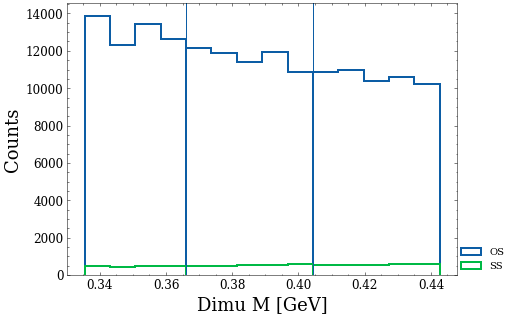

In [7]:
index = 2

loc_SB_left = bin_definitions["SB_left"][index]
loc_SB_right = bin_definitions["SB_right"][index]
loc_SR_left = bin_definitions["SR_left"][index]
loc_SR_right = bin_definitions["SR_right"][index]

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(loc_SR_left, loc_SR_right, loc_SB_left, loc_SB_right, num_bins_SR= 6)


plt.figure(figsize = (7,5))

x = np.linspace(loc_SB_left, loc_SB_right, 100) # plot curve fit

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= loc_SB_left) & (cut_data[code]["dimu_mass"] <= loc_SB_right)]
masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= loc_SB_left) & (cut_data_samesign[code]["dimu_mass"] <= loc_SB_right)]


plt.hist(masses_with_bounds, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"OS")
plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"SS")


plt.axvline(loc_SR_left)
plt.axvline(loc_SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

#plt.yscale("log")

plt.show()

 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [8]:
from sklearn.preprocessing import StandardScaler


bands = ["SBL", "SR", "SBH"]
N_total_events = 0
N_total_events_samesign = 0

for i in range(len(bin_definitions["SR_left"])):
    
    # define SR, SB

    loc_SB_left = bin_definitions["SB_left"][i]
    loc_SB_right = bin_definitions["SB_right"][i]
    loc_SR_left = bin_definitions["SR_left"][i]
    loc_SR_right = bin_definitions["SR_right"][i]
    
    print(f"SB bounds: {loc_SB_left}, {loc_SB_right}")
    print(f"SR bounds: {loc_SR_left}, {loc_SR_right}")

    band_bounds = {"SBL": [loc_SB_left, loc_SR_left],
                       "SR": [loc_SR_left, loc_SR_right],
                       "SBH": [loc_SR_right, loc_SB_right],
                               }
    
    # preprocess the data

    preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}

    for code in codes_list:
        for b in bands:

            # opp sign
            loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts[b][code] = {}
            for feat in feature_set:
                preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            N_total_events += preproc_dicts[b][code][feat].shape[0]

            # same sign
            loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
            preproc_dicts_samesign[b][code] = {}
            for feat in feature_set:
                preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
            N_total_events_samesign += preproc_dicts_samesign[b][code][feat].shape[0]

    print(f"Total events opp sign: {N_total_events}")
    print(f"Total events same sign: {N_total_events_samesign}")
    
    
    # transformed / preprocess data
    
    sizes_dict, sizes_dict_samesign = {}, {}

    proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}

    for feat in feature_set: 

        # train the preprocessor on the opp sign data only
        data_SB = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)

        if feat == "dimu_mass": # don't logit transform
            mass_scaler = StandardScaler()
            mass_scaler = mass_scaler.fit(data_SB)

            with open(f"{working_dir}/projects/{scaler_id}/processed_data/mass_scaler_{i}", "wb") as ofile:
                pickle.dump(mass_scaler, ofile)

            for b in bands:
                proccessed_data_dict[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1,1))
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1,1))
                sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
                sizes_dict_samesign[b] = proccessed_data_dict_samesign[b]["s_inj_data"][feat].shape[0]

        else: 
            data_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat], preproc_dicts["SR"][sim_id][feat])).reshape(-1, 1)
            all_min = np.min(data_all)
            all_max = np.max(data_all)
            # logit transform the features
            transformed_feats = logit_transform(data_SB, all_min, all_max)
            # subtract off mean, std of the training set
            mean_to_sub = np.mean(transformed_feats)
            std_to_sub = np.std(transformed_feats)

            for b in bands:
                proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub
                proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub

    print(sizes_dict)
    print(sizes_dict_samesign)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{i}_samesign_nojet_test_band_data", "wb") as ofile:
        pickle.dump(proccessed_data_dict_samesign, ofile)


    print()


SB bounds: 0.3, 0.40435467459987157
SR bounds: 0.3313866376233613, 0.36605701198438995
Total events opp sign: 178673
Total events same sign: 6466
{'SBL': 61149, 'SR': 59293, 'SBH': 58231}
{'SBL': 1781, 'SR': 2126, 'SBH': 2559}

SB bounds: 0.31530301502999997, 0.4249808268093802
SR bounds: 0.3482906866109995, 0.38472959850516997


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 356240
Total events same sign: 13497
{'SBL': 60654, 'SR': 58601, 'SBH': 58312}
{'SBL': 1935, 'SR': 2324, 'SBH': 2772}

SB bounds: 0.3313866376233613, 0.44665912007646613
SR bounds: 0.36605701198438995, 0.40435467459987157


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 531995
Total events same sign: 21224
{'SBL': 59293, 'SR': 58231, 'SBH': 58231}
{'SBL': 2126, 'SR': 2559, 'SBH': 3042}

SB bounds: 0.3482906866109995, 0.4694432241691886
SR bounds: 0.38472959850516997, 0.4249808268093802


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 706763
Total events same sign: 29625
{'SBL': 58601, 'SR': 58312, 'SBH': 57855}
{'SBL': 2324, 'SR': 2772, 'SBH': 3305}

SB bounds: 0.36605701198438995, 0.49338954655316436
SR bounds: 0.40435467459987157, 0.44665912007646613


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 881286
Total events same sign: 38673
{'SBL': 58231, 'SR': 58231, 'SBH': 58061}
{'SBL': 2559, 'SR': 3042, 'SBH': 3447}

SB bounds: 0.38472959850516997, 0.5185573720416575
SR bounds: 0.4249808268093802, 0.4694432241691886


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1056227
Total events same sign: 48481
{'SBL': 58312, 'SR': 57855, 'SBH': 58774}
{'SBL': 2772, 'SR': 3305, 'SBH': 3731}

SB bounds: 0.40435467459987157, 0.5450090095692268
SR bounds: 0.44665912007646613, 0.49338954655316436


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1233279
Total events same sign: 58933
{'SBL': 58231, 'SR': 58061, 'SBH': 60760}
{'SBL': 3042, 'SR': 3447, 'SBH': 3963}

SB bounds: 0.4249808268093802, 0.5728099464523044
SR bounds: 0.4694432241691886, 0.5185573720416575


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1413782
Total events same sign: 70197
{'SBL': 57855, 'SR': 58774, 'SBH': 63874}
{'SBL': 3305, 'SR': 3731, 'SBH': 4228}

SB bounds: 0.44665912007646613, 0.6020290105186149
SR bounds: 0.49338954655316436, 0.5450090095692268
Total events opp sign: 1597964
Total events same sign: 82212
{'SBL': 58061, 'SR': 60760, 'SBH': 65361}
{'SBL': 3447, 'SR': 3963, 'SBH': 4605}

SB bounds: 0.4694432241691886, 0.6327385405068229
SR bounds: 0.5185573720416575, 0.5728099464523044


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1787242
Total events same sign: 94972
{'SBL': 58774, 'SR': 63874, 'SBH': 66630}
{'SBL': 3731, 'SR': 4228, 'SBH': 4801}

SB bounds: 0.49338954655316436, 0.6650145651582768
SR bounds: 0.5450090095692268, 0.6020290105186149


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 1983453
Total events same sign: 108699
{'SBL': 60760, 'SR': 65361, 'SBH': 70090}
{'SBL': 3963, 'SR': 4605, 'SBH': 5159}

SB bounds: 0.5185573720416575, 0.6989369914442302
SR bounds: 0.5728099464523044, 0.6327385405068229
Total events opp sign: 2188728
Total events same sign: 123321
{'SBL': 63874, 'SR': 66630, 'SBH': 74771}
{'SBL': 4228, 'SR': 4801, 'SBH': 5593}

SB bounds: 0.5450090095692268, 0.7345898023945437
SR bounds: 0.6020290105186149, 0.6650145651582768


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2405293
Total events same sign: 139056
{'SBL': 65361, 'SR': 70090, 'SBH': 81114}
{'SBL': 4605, 'SR': 5159, 'SBH': 5971}

SB bounds: 0.5728099464523044, 0.7720612650176386
SR bounds: 0.6327385405068229, 0.6989369914442302


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 2644019
Total events same sign: 155805
{'SBL': 66630, 'SR': 74771, 'SBH': 97325}
{'SBL': 4801, 'SR': 5593, 'SBH': 6355}

SB bounds: 0.6020290105186149, 0.8114441488264578
SR bounds: 0.6650145651582768, 0.7345898023945437
Total events opp sign: 2922615
Total events same sign: 173667
{'SBL': 70090, 'SR': 81114, 'SBH': 127392}
{'SBL': 5159, 'SR': 5971, 'SBH': 6732}

SB bounds: 0.6327385405068229, 0.8528359555114471
SR bounds: 0.6989369914442302, 0.7720612650176386
Total events opp sign: 3216364
Total events same sign: 192675
{'SBL': 74771, 'SR': 97325, 'SBH': 121653}
{'SBL': 5593, 'SR': 6355, 'SBH': 7060}

SB bounds: 0.6650145651582768, 0.8963391603291674
SR bounds: 0.7345898023945437, 0.8114441488264578
Total events opp sign: 3523189
Total events same sign: 212753
{'SBL': 81114, 'SR': 127392, 'SBH': 98319}
{'SBL': 5971, 'SR': 6732, 'SBH': 7375}

SB bounds: 0.6989369914442302, 0.9420614658041502
SR bounds: 0.7720612650176386, 0.8528359555114471
Total events opp sign

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 4985463
Total events same sign: 304989
{'SBL': 98319, 'SR': 109768, 'SBH': 199860}
{'SBL': 7375, 'SR': 8324, 'SBH': 9224}

SB bounds: 0.8528359555114471, 1.1494940175930064
SR bounds: 0.9420614658041502, 1.0406219386245752
Total events opp sign: 5424889
Total events same sign: 331256
{'SBL': 100912, 'SR': 176393, 'SBH': 162121}
{'SBL': 7831, 'SR': 8745, 'SBH': 9691}

SB bounds: 0.8963391603291674, 1.2081297650200757
SR bounds: 0.9901160683720992, 1.093704115848974


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 5899923
Total events same sign: 358801
{'SBL': 109768, 'SR': 199860, 'SBH': 165406}
{'SBL': 8324, 'SR': 9224, 'SBH': 9997}

SB bounds: 0.9420614658041502, 1.269756524861051
SR bounds: 1.0406219386245752, 1.1494940175930064


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 6412998
Total events same sign: 387607
{'SBL': 176393, 'SR': 162121, 'SBH': 174561}
{'SBL': 8745, 'SR': 9691, 'SBH': 10370}

SB bounds: 0.9901160683720992, 1.3345268688090148
SR bounds: 1.093704115848974, 1.2081297650200757


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 6964157
Total events same sign: 417743
{'SBL': 199860, 'SR': 165406, 'SBH': 185893}
{'SBL': 9224, 'SR': 9997, 'SBH': 10915}

SB bounds: 1.0406219386245752, 1.4026011512467589
SR bounds: 1.1494940175930064, 1.269756524861051


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)
/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 7498486
Total events same sign: 449445
{'SBL': 162121, 'SR': 174561, 'SBH': 197647}
{'SBL': 9691, 'SR': 10370, 'SBH': 11641}

SB bounds: 1.093704115848974, 1.4741479062421736
SR bounds: 1.2081297650200757, 1.3345268688090148
Total events opp sign: 8058422
Total events same sign: 482676
{'SBL': 165406, 'SR': 185893, 'SBH': 208637}
{'SBL': 9997, 'SR': 10915, 'SBH': 12319}

SB bounds: 1.1494940175930064, 1.549344264794397
SR bounds: 1.269756524861051, 1.4026011512467589


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 8650659
Total events same sign: 517587
{'SBL': 174561, 'SR': 197647, 'SBH': 220029}
{'SBL': 10370, 'SR': 11641, 'SBH': 12900}

SB bounds: 1.2081297650200757, 1.628376393363707
SR bounds: 1.3345268688090148, 1.4741479062421736
Total events opp sign: 9276337
Total events same sign: 554282
{'SBL': 185893, 'SR': 208637, 'SBH': 231148}
{'SBL': 10915, 'SR': 12319, 'SBH': 13461}

SB bounds: 1.269756524861051, 1.711439954770847
SR bounds: 1.4026011512467589, 1.549344264794397


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 9935338
Total events same sign: 593192
{'SBL': 197647, 'SR': 220029, 'SBH': 241325}
{'SBL': 11641, 'SR': 12900, 'SBH': 14369}

SB bounds: 1.3345268688090148, 1.7987405926068498
SR bounds: 1.4741479062421736, 1.628376393363707


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 10626186
Total events same sign: 634199
{'SBL': 208637, 'SR': 231148, 'SBH': 251063}
{'SBL': 12319, 'SR': 13461, 'SBH': 15227}

SB bounds: 1.4026011512467589, 1.890494440352629
SR bounds: 1.549344264794397, 1.711439954770847


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 11348477
Total events same sign: 677158
{'SBL': 220029, 'SR': 241325, 'SBH': 260937}
{'SBL': 12900, 'SR': 14369, 'SBH': 15690}

SB bounds: 1.4741479062421736, 1.986928656468788
SR bounds: 1.628376393363707, 1.7987405926068498


/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


Total events opp sign: 12100731
Total events same sign: 722261
{'SBL': 231148, 'SR': 251063, 'SBH': 270043}
{'SBL': 13461, 'SR': 15227, 'SBH': 16415}



/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


## Preprocessing

Standard scaling is fine

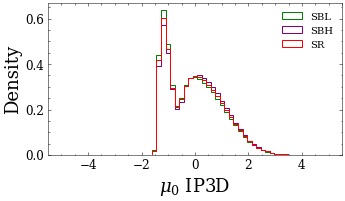

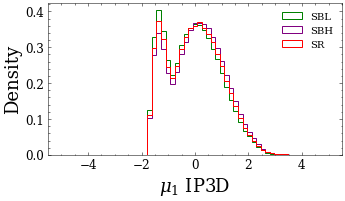

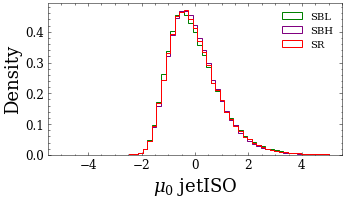

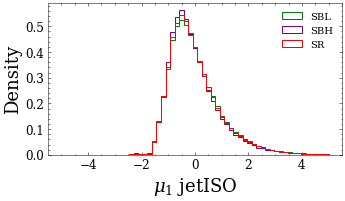

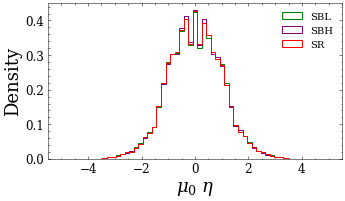

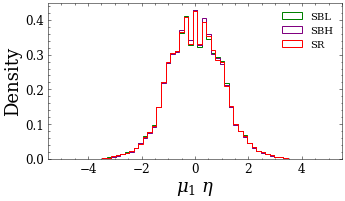

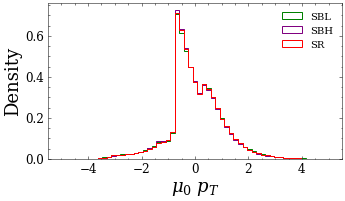

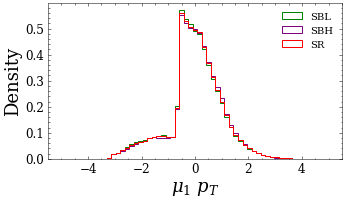

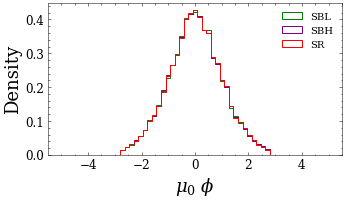

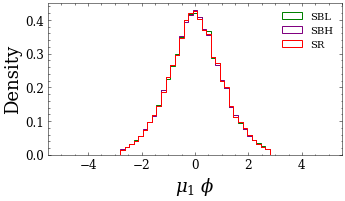

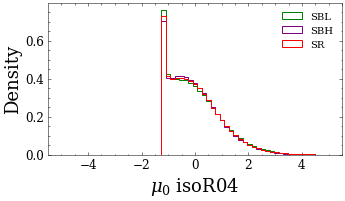

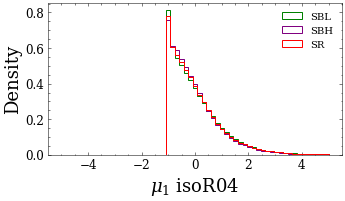

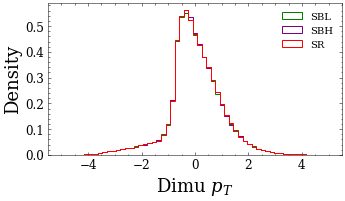

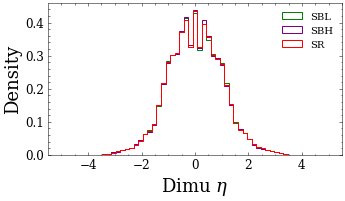

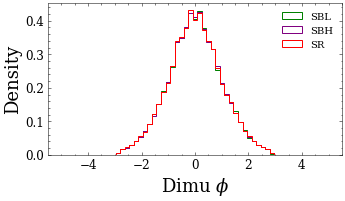

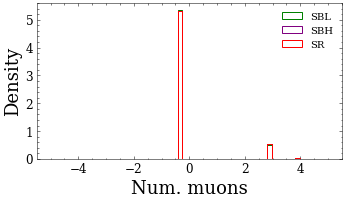

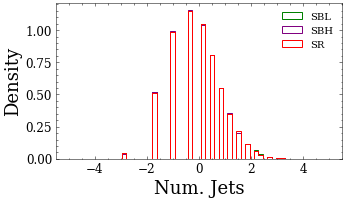

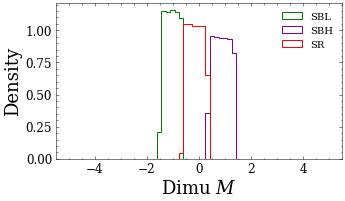

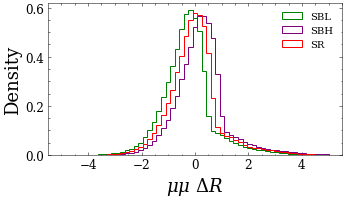

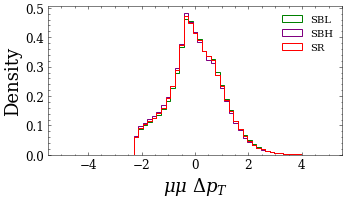

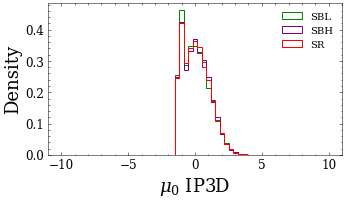

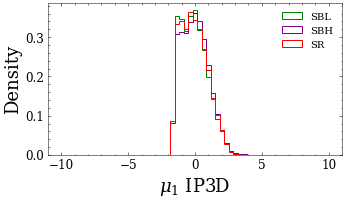

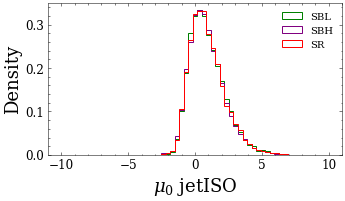

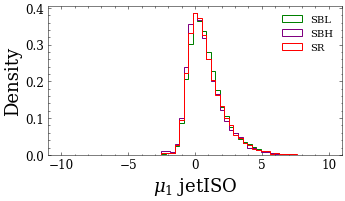

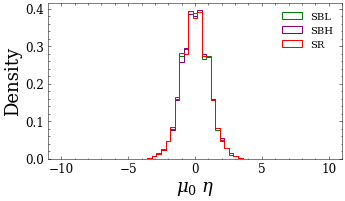

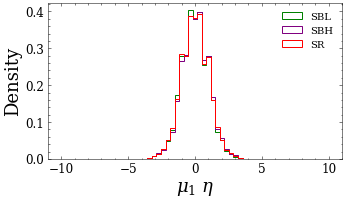

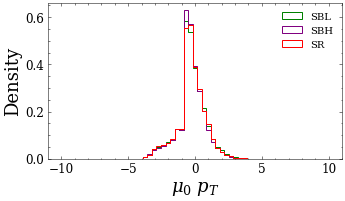

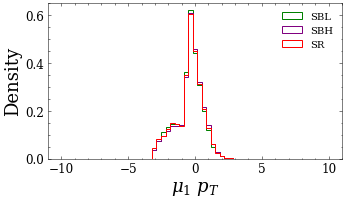

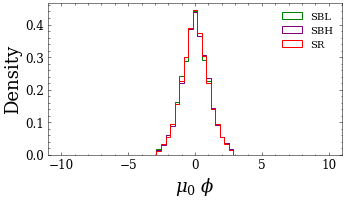

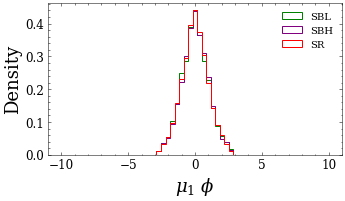

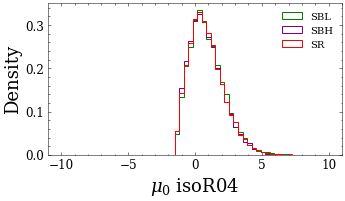

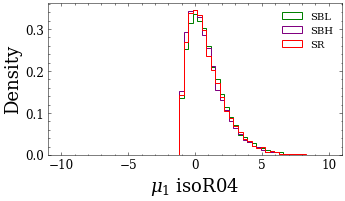

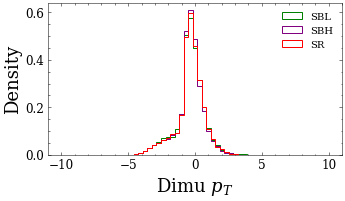

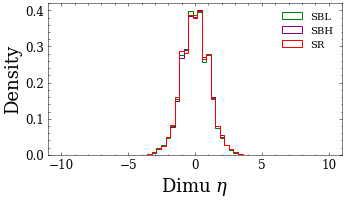

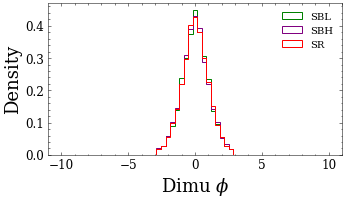

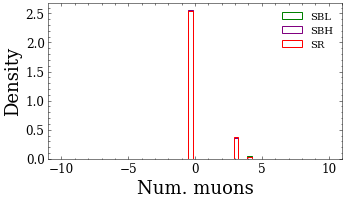

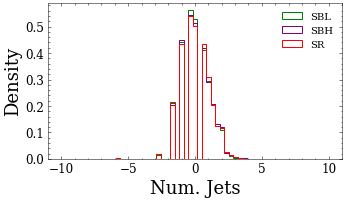

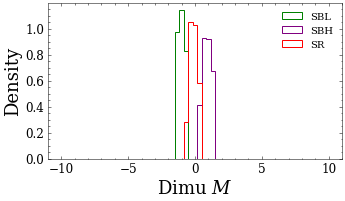

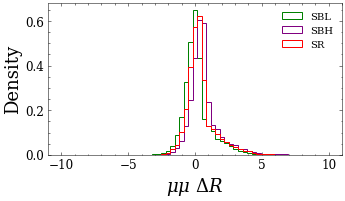

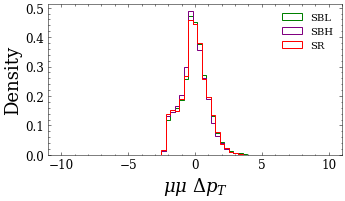

In [9]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





Create a batch script for flow training


In [10]:
feature_sets = workflow["feature_sets"]

if run_jet: jet_id = "jet"
else:jet_id = "nojet"

num_windows = len(bin_definitions["SB_left"])
    
    
    
batches_to_run = ["single_3"]

with open("batch_lowmass_scan_05.sh", "w") as ofile:
    
    ofile.write("#!/bin/sh \n\n")
    ofile.write("#SBATCH -N 1\n")
    ofile.write("#SBATCH -C gpu\n")
    ofile.write("#SBATCH -G 1\n")
    ofile.write("#SBATCH -q regular\n")
    ofile.write("#SBATCH --job-name=lowmass_scan\n")
    ofile.write("#SBATCH --mail-user=rmastand@berkeley.edu\n")
    ofile.write("#SBATCH --mail-type=ALL\n")
    ofile.write("#SBATCH -t 4:00:00\n")
    ofile.write("#SBATCH -A m3246\n")
    ofile.write(f"#SBATCH --array=0-{2*num_windows-1}\n\n")
    ofile.write(f"declare -a commands=(\n")

    i = 0

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = 2*i, jet_id = jet_id )
            ofile.write(loc_command)
            ofile.write("\n")
            loc_command = '[{i}]="python 05_trueCATHODE.py -fid {feature_set} -f {feature_list},dimu_mass -pid lowmass_{window_index}_samesign_{jet_id} -c CATHODE_8 -seed 1 -did lowmass_scan"'.format(feature_set=fs,feature_list = ",".join(feature_sets[fs]), window_index = window_index, i = 2*i+1, jet_id = jet_id )
            ofile.write(loc_command)
            ofile.write("\n")
            i += 1

    ofile.write(f")\n")
    ofile.write(f"srun ${{commands[$SLURM_ARRAY_TASK_ID]}}")



In [11]:
with open("batch_lowmass_scan_06.sh", "w") as ofile:

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 06_eval_CATHODE.py -f {fs} -p {window_index}_samesign -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")

In [14]:
n_ensemble = 5
n_bootstrap = 5
with open("batch_lowmass_scan_07.sh", "w") as ofile:

    for fs in batches_to_run:
        for window_index in range(num_windows): 

            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
            loc_command = f'python 07_bump_hunt_boostrap.py -f {fs} -p {window_index} -train_samesign -ne {n_ensemble} -nb {n_bootstrap} -did lowmass_scan'
            if run_jet:
                loc_command += " -run_jet"
            ofile.write(loc_command+"\n")
